# Librerias 


In [511]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import numpy as np

# Importación de Datasets

In [512]:
url_train = 'https://raw.githubusercontent.com/FrancoSecchi/7506R-1C2023-GRUPO02/master/hotels_train.csv'
url_test = 'https://raw.githubusercontent.com/FrancoSecchi/7506R-1C2023-GRUPO02/master/hotels_test.csv'
df_train = pd.read_csv(url_train)
df_test = pd.read_csv(url_test)

In [513]:
df_train.head(2)

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,id,is_canceled
0,City Hotel,49,2016,September,37,5,1,2,1,0.0,...,9.0,NaN,0,Transient,115.5,0,1,2016-08-25,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1
1,Resort Hotel,4,2015,October,44,31,0,1,2,0.0,...,NaN,NaN,0,Transient,42.0,1,0,2015-11-01,b1428f80-c56c-4ae4-91a9-6962edae08b1,0


In [514]:
df_hotels_train = df_train.copy()
df_hotels_test = df_test.copy()

# Funciones auxiliares

In [515]:
def showBarPlot(column: str, title: str, x_label: str, y_label: str, alpha = 0.5, showPercentage = False, df_hotels = df_hotels_train) -> None: 
  if (showPercentage):
    data = df_hotels[column].value_counts(normalize=True) * 100
    x = data.index
  else: 
    data = df_hotels[column].value_counts()


  if (column == "arrival_date_month"):
    x = data.index.str.slice(stop=3)

  ax = sns.barplot(x=x, y=data.values, alpha=alpha)

  if (showPercentage):
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom')

  ax.set(title = title, ylabel = y_label, xlabel = x_label)
  plt.show()

In [516]:
from textwrap import dedent
showBarPlot.__doc__ = dedent("""\
    Muestra un gráfico de barras con porcentages en las barras con respecto al total del dataset.

    Parámetros
    -------
    - ``column`` (str): Nombre de la columna.
    - ``title`` (str): Titulo gráfico.
    - ``x_label`` (str): Nombre eje x.
    - ``y_label`` (str): Nombre eje y.
    - ``alpha`` (float or int): Transpariencia de las barras.
    - ``showPercentage`` (bool): Indica si se desea mostrar los porcentages de las barras.
    - ``df_hotels`` (DataFrame): DataFrame a graficar.

    Retorna
    -------
    None
  """)

In [517]:

import datetime
def weekNumberToMonth(year: int, week_number: int) -> str : 
  """
    Convierte el numero de semana del año en un mes
    Parámetros 
    -------
    year (int) : Año 
    week_number (int) : Numero de semana a convertir

    Retorna
    -------
    El Mes abreviado en 3 letras
  """
  date = datetime.datetime.strptime(f'{year}-W{week_number}-1', '%Y-W%W-%w')
  return date.strftime('%B')[:3]

def sortByMonth(df) -> None :
  """
    Ordena la columna de meses de menor a mayor. El dataset debe contener una columna llamada arrival_date_month, que contenga los meses abreviados en 3.
    Parámetros
    -------
    df (DataFrame): DataFrame a ordenar

    Retrona
    -------
    None
  """
  months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
  df['arrival_date_month'] = pd.Categorical(df['arrival_date_month'], categories=months, ordered=True)
  df.sort_values('arrival_date_month', inplace=True)

In [518]:
def cramers_v(categorical_var1: pd.Series, categorical_var2: pd.Series) -> float:
    """
    Calcula el coeficiente de Cramér's V entre dos variables categóricas.

    Parámetros:
    - categorical_var1: Serie de Pandas que representa la primera variable categórica.
    - categorical_var2: Serie de Pandas que representa la segunda variable categórica.

    Devuelve:
    - Coeficiente de Cramér's V (float) que mide la asociación entre las dos variables categóricas.
    """

    confusion_matrix = pd.crosstab(categorical_var1,categorical_var2)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# 1) Análisis Exploratorio y Preprocesamiento de Datos


 ## Análisis del tipo de variable

In [519]:
print(df_hotels_train.shape)
df_hotels_train.dtypes

(61913, 32)


hotel                              object
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             float64
company                           

### Datos a analizar para la ingenieria de datos
Variables a revisar
- Adults: Ver caso en el que no hay adultos 
- Meals: Cambiar Undefined por SC (en el paper especifica que son lo mismo)
- Children: pasar a int
- Country: pasar de iso a String, revisar caso nan
- Company - agent: pasar a int
- adr: casos negativos
- reservation_status: eliminar
- reservation_status_date: probablemente haya que borrarlo

#### `hotel`
  - Descripción: Nombre del Hotel
  - Tipo de dato: Cualitativa
  - Valores posibles: City Hotel, Resort Hotel 
  - Frecuencia: City Hotel 68.05% , Resort Hotel 31,95%
 

In [520]:
# Valores posibles
df_hotels_train['hotel'].unique()

array(['City Hotel', 'Resort Hotel'], dtype=object)

In [521]:
#Frecuencia de los valores posibles
round(df_hotels_train['hotel'].value_counts(normalize=True) * 100, 2)

City Hotel      68.05
Resort Hotel    31.95
Name: hotel, dtype: float64

##### Distribución


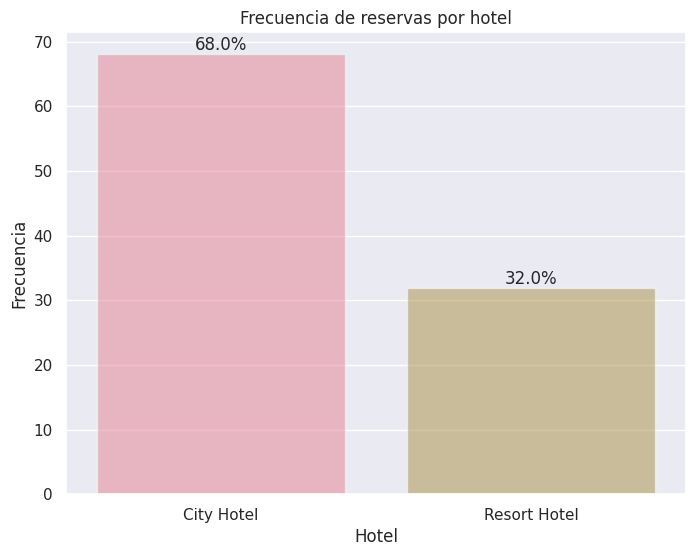

In [522]:
showBarPlot('hotel', "Frecuencia de reservas por hotel", x_label= 'Hotel', y_label="Frecuencia", showPercentage = True)

Con el gráfico de distribucion de las reservas por hotel, podemos observar que en la maoyría de los casos las reservas son para "City Hotel" y el restante para "Resort Hotel". 

Del 100% de las reservas, que en total son 61913, 42100 pertenecen al hotel _City_ y las 19812 reservas restantes pertenecen al hotel _Resort_.

#### --------------------------------------------------------------------------

#### `lead_time`
  - Descripción: Diferencia de dias entre la compra de la reserva y la alojamiento del cliente
  - Tipo de dato: Cuantitativa
  - Medidas de resumen: _ver en código_
  - Distribución: _ver en código_



In [523]:
# Medidas
round(df_hotels_train['lead_time'].describe(), 2)

count    61913.00
mean       112.25
std        110.72
min          0.00
25%         23.00
50%         78.00
75%        172.00
max        629.00
Name: lead_time, dtype: float64

- ##### Distribución


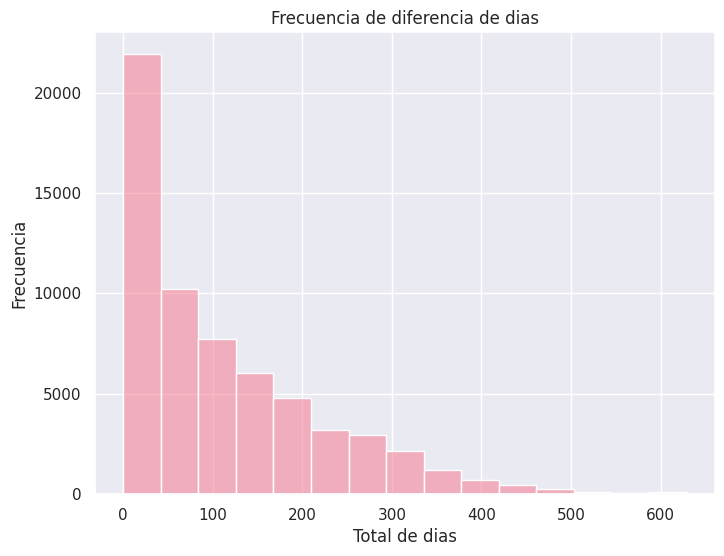

In [524]:
sns_hist=sns.histplot(data=df_hotels_train['lead_time'], alpha = 0.5, bins = 15).set(title="Frecuencia de diferencia de dias", xlabel="Total de dias", ylabel="Frecuencia")

Podemos analizar que mayormente la diferencia de días entre que se efectua la reserva y el cliente se aloja, es menor a los 25 días.

#### --------------------------------------------------------------------------

#### Variables de fecha de llegada
  - `arrival_date_year`
    - Descripcion: Año de llegada
    - Tipo de dato: Cuantitativa
    - Medidas de resumen: [ver en código](#info-años)
    - Distribución: _ver en código_
  - `arrival_date_month`
    - Descripcion: Mes de llegada
    - Tipo de dato: Cualitativa
    - Valores posibles: Todos los meses
    - Frecuencia: [ver en código](#info-meses)
  - `arrival_date_week_number`
    - Descripcion: Número de semana de la fecha de llegada. Es con respecto al año, no al mes.
    - Tipo de dato: Cuantitativa
    - Medidas de resumen: [ver en código](#info-numero-semana-año)
    - Distribución: _ver en código_
  - `arrival_date_day_of_month`
    - Descripcion: Número del dia del mes de la fecha de llegada.
    - Tipo de dato: Cuantitativa
    - Medidas de resumen: [ver en código](#info-numero-dia-mes)
    - Distribución: _ver en código_

<a name="info-años"> </a>
##### Información de _**los años**_

  - ###### Medidas

In [525]:
# Medidas de los años
round(df_hotels_train['arrival_date_year'].describe(), 2)

count    61913.00
mean      2016.15
std          0.71
min       2015.00
25%       2016.00
50%       2016.00
75%       2017.00
max       2017.00
Name: arrival_date_year, dtype: float64

- ###### Distribución

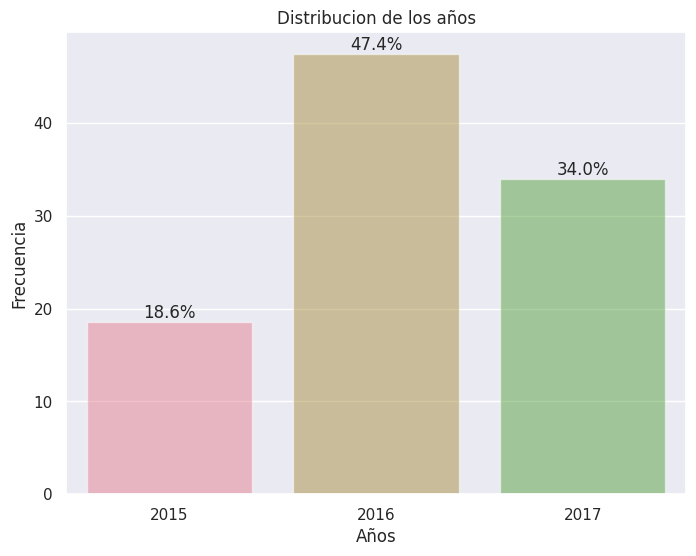

In [526]:
showBarPlot('arrival_date_year', "Distribucion de los años", x_label= 'Años', y_label="Frecuencia", showPercentage = True)

Podemos observar en el año 2016 se hicieron la mayoria de las reservas.

<a name="info-meses"> </a>
##### Información de _**los meses**_

- ###### Frecuencia

In [527]:
round(df_hotels_train['arrival_date_month'].value_counts(normalize=True) * 100, 2)

August       11.59
July         10.54
May           9.95
April         9.49
October       9.47
June          9.32
September     9.08
March         7.91
February      6.66
December      5.64
November      5.50
January       4.85
Name: arrival_date_month, dtype: float64

Idea: Agregar una columna que sea arrival_date, que sea de tipo Date (de pandas)

- ###### Distribución


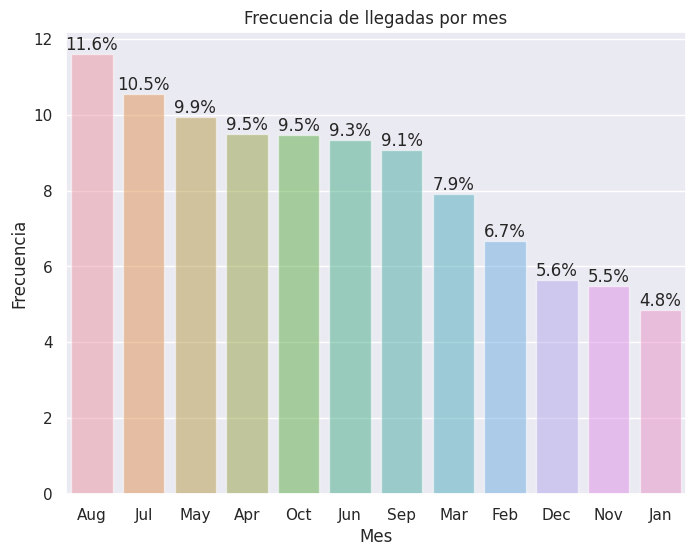

In [528]:
showBarPlot('arrival_date_month', "Frecuencia de llegadas por mes", x_label= 'Mes', y_label="Frecuencia", showPercentage = True)

Podemos observar que la mayoria de las reservas fueron hechas en el mes de Agosto y Julio. Podemos considerar que es en la epoca de invierno del hemisferio norte.

<a name="info-numero-semana-año"> </a>
##### Información del _**numero de semana del año**_

- ###### Medidas

In [529]:
round(df_hotels_train['arrival_date_week_number'].describe(), 2)

count    61913.00
mean        27.22
std         13.53
min          1.00
25%         16.00
50%         28.00
75%         38.00
max         53.00
Name: arrival_date_week_number, dtype: float64

- ###### Distribución

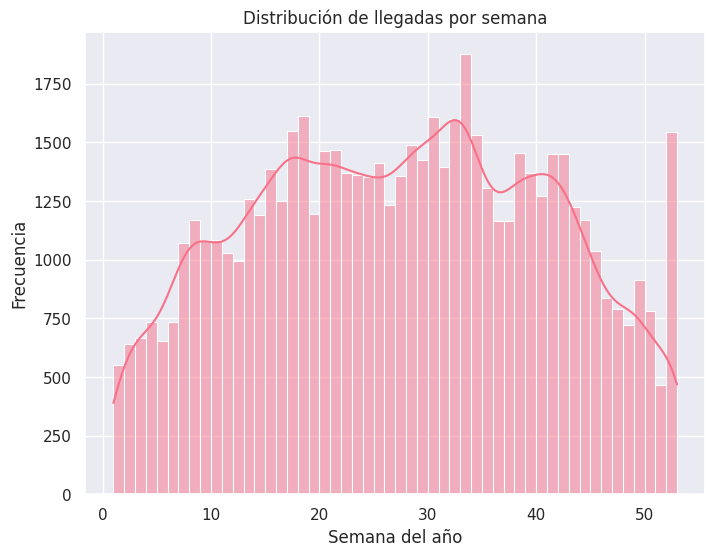

In [530]:
WEEKS_PER_YEAR = 52
histplot = sns.histplot(data = df_hotels_train, x = "arrival_date_week_number", bins = WEEKS_PER_YEAR, kde=True).set(title = "Distribución de llegadas por semana", ylabel = "Frecuencia", xlabel = "Semana del año") 

Podemos observar que entre la semana 31, que sería agosto, y la semana 35, que tambien es agosto, es en donde se produce el pico de reservas. En la ultima semana del año tambien se registraron muchas reservas.

<a name="info-numero-dia-mes"> </a>
##### Información del _**numero del mes**_

- ###### Medidas

In [531]:
round(df_hotels_train['arrival_date_day_of_month'].describe(), 2)

count    61913.00
mean        15.79
std          8.80
min          1.00
25%          8.00
50%         16.00
75%         23.00
max         31.00
Name: arrival_date_day_of_month, dtype: float64

- ###### Distribución

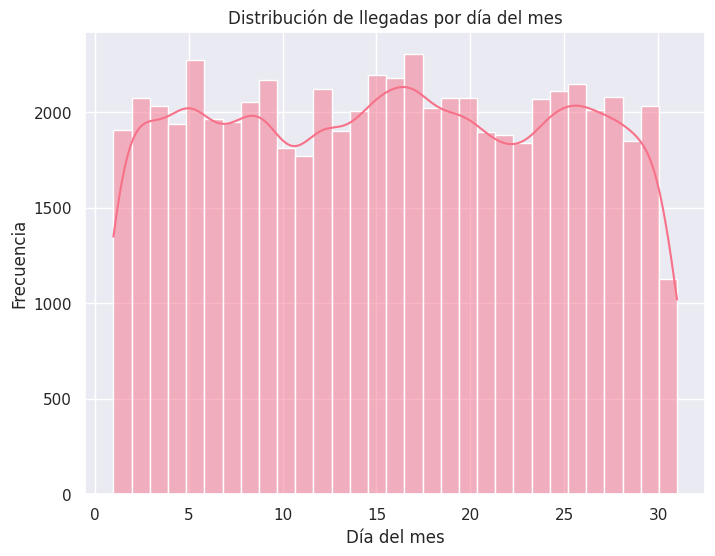

In [532]:
DAYS_PER_MONTH = 31
histplot = sns.histplot(data = df_hotels_train, x = "arrival_date_day_of_month", bins = DAYS_PER_MONTH, kde=True).set(title = "Distribución de llegadas por día del mes", ylabel = "Frecuencia", xlabel = "Día del mes")

Podemos observar que la repartición de reservas segun el día, tiende a ser equitativa.

#### --------------------------------------------------------------------------

#### Variables de cantidad de noches
  - `stays_in_weekend_nights`
    - Descripción: Cuantas noches son en fines de semana  
    - Tipo de dato: Cuantitativa
    - Medidas de resumen: [ver en código](#info-noches-fin-semana)
    - Distribución: _ver en código_
  - `stays_in_weeks_nights`
    - Descripción: Cuantas noches son en días de semana  
    - Tipo de dato: Cuantitativa
    - Medidas de resumen: [ver en código](#info-noches-semana)  
    - Distribución: _ver en código_

<a name="info-noches-fin-semana"> </a>
##### Información de _**la cantidad noches de fin de semana**_

  - ###### Medidas

In [533]:
round(df_hotels_train['stays_in_weekend_nights'].describe(), 2)

count    61913.00
mean         0.92
std          0.99
min          0.00
25%          0.00
50%          1.00
75%          2.00
max         16.00
Name: stays_in_weekend_nights, dtype: float64

- ###### Distribución

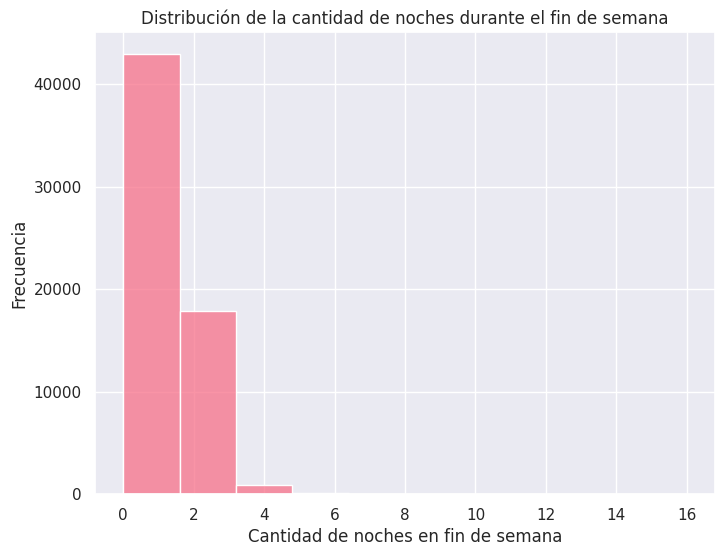

In [534]:
histplot = sns.histplot(data = df_hotels_train, x = "stays_in_weekend_nights", bins = 10).set(title = "Distribución de la cantidad de noches durante el fin de semana", ylabel = "Frecuencia", xlabel = "Cantidad de noches en fin de semana")

La mayoria de los clientes eligen quedarse una noche en el fin de semana

<a name="info-noches-semana"> </a>
##### Información de _**la cantidad noches de semana**_

  - ###### Medidas

In [535]:
round(df_hotels_train['stays_in_week_nights'].describe(), 2)

count    61913.00
mean         2.51
std          1.88
min          0.00
25%          1.00
50%          2.00
75%          3.00
max         40.00
Name: stays_in_week_nights, dtype: float64

- ###### Distribución

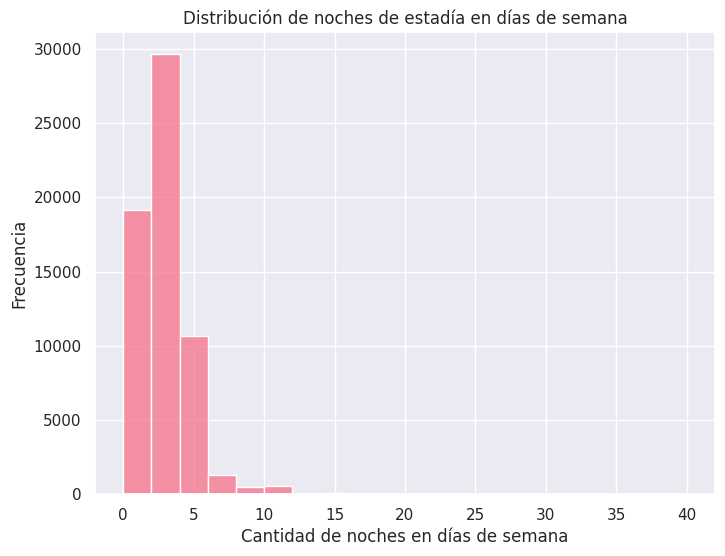

In [536]:
histplot = sns.histplot(data = df_hotels_train, x = "stays_in_week_nights", bins = 20).set(title = "Distribución de noches de estadía en días de semana", ylabel = "Frecuencia", xlabel = "Cantidad de noches en días de semana")

Podemos observar que la mayoria de los clientes reservan aproximadamente entre 1 y 5 noches que son en dia de semana.

#### --------------------------------------------------------------------------

#### `adults`
  - Descripción: Cantidad de adultos en la reserva
  - Tipo de dato: Cuantitativa
  - Medidas de resumen: _ver en código_
  - Distribución: _ver en código_ 


  - ###### Medidas

In [537]:
round(df_hotels_train['adults'].describe(), 2)

count    61913.00
mean         1.86
std          0.59
min          0.00
25%          2.00
50%          2.00
75%          2.00
max         55.00
Name: adults, dtype: float64

  - ###### Distribución

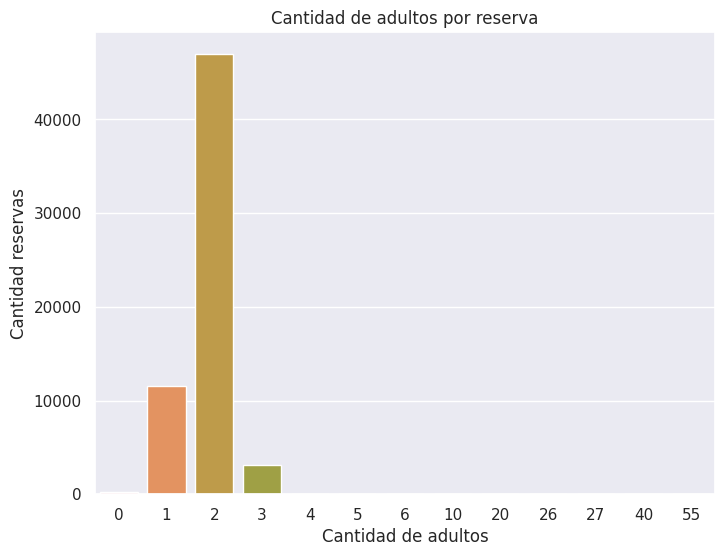

In [538]:
plot = sns.countplot(x='adults', data=df_hotels_train).set(title = "Cantidad de adultos por reserva", ylabel = "Cantidad reservas", xlabel = "Cantidad de adultos")

En la mayoria de las reservas, se registraron 2 adultos. Y en un caso particular no se registraron adultos.

#### --------------------------------------------------------------------------

#### `children`
  - Descripción: Cantidad de niños en la reserva
  - Tipo de dato: Cuantitativa
  - Medidas de resumen: _ver en código_
  - Distribución: _ver en código_

  - ###### Medidas

In [539]:
round(df_hotels_train['children'].describe(), 2)

count    61909.0
mean         0.1
std          0.4
min          0.0
25%          0.0
50%          0.0
75%          0.0
max         10.0
Name: children, dtype: float64

  - ###### Distribución

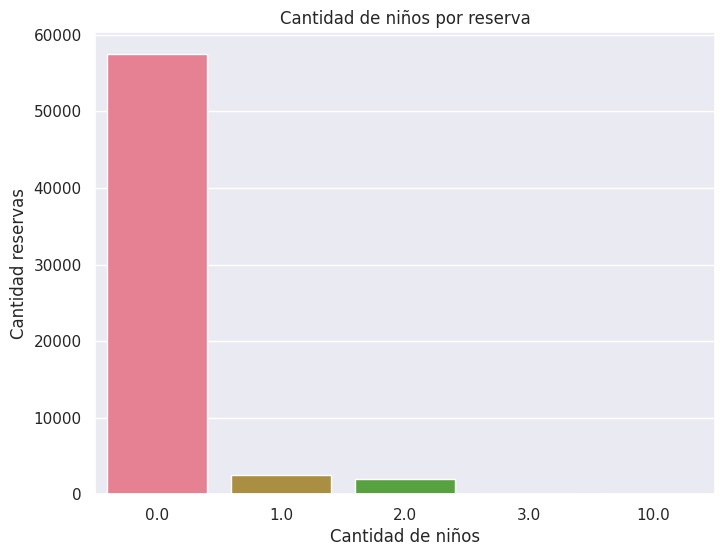

In [540]:
plot = sns.countplot(x='children', data=df_hotels_train).set(title = "Cantidad de niños por reserva", ylabel = "Cantidad reservas", xlabel = "Cantidad de niños")

La mayoria de las reservas no alojan niños

#### --------------------------------------------------------------------------

#### `babies`
  - Descripción: Cantidad de bebes en la reserva
  - Tipo de dato: Cuantitativa
  - Medidas de resumen: _ver en código_
  - Distribución: _ver en código_

  - ###### Medidas

In [541]:
round(df_hotels_train['babies'].describe(), 2)

count    61913.00
mean         0.01
std          0.09
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          9.00
Name: babies, dtype: float64

  - ###### Distribución

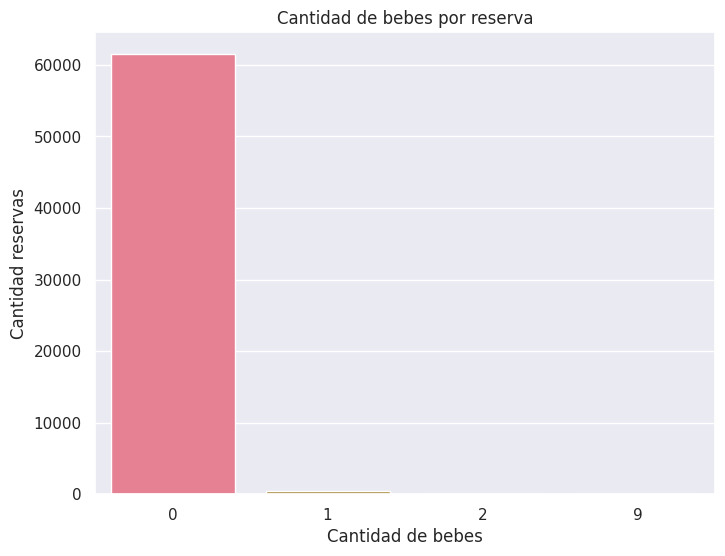

In [542]:
plot = sns.countplot(x='babies', data=df_hotels_train).set(title = "Cantidad de bebes por reserva", ylabel = "Cantidad reservas", xlabel = "Cantidad de bebes")

Al igual que con los niños, la mayoria no registro bebes. 

#### --------------------------------------------------------------------------

#### `meal`
  - Descripción: Comidas que el cliente solicito
  - Tipo de dato: Cualitativas
  - Valores posibles: BB, HB, SC/UNDEFINED, FB
  - Frecuencia: _ver en código_ 


- ###### Frecuencia


In [543]:
round(df_hotels_train['meal'].value_counts(normalize=True) * 100, 2)

BB           77.26
HB           12.04
SC            8.97
Undefined     0.95
FB            0.77
Name: meal, dtype: float64

- ###### Distribución


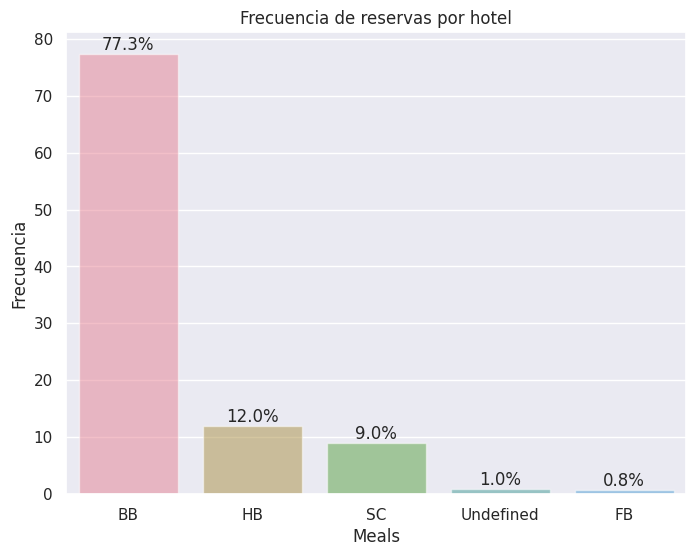

In [544]:
showBarPlot('meal', "Frecuencia de reservas por hotel", x_label= 'Meals', y_label="Frecuencia", showPercentage = True)

La mayoria de las reservas registraron que el cliente quiere el paquete de BB (Bed & Breakfast)

#### --------------------------------------------------------------------------

#### `country`
  - Descripción: Pais de origen de la reserva
  - Tipo de dato: Cualitativas
  - Valores posibles: _ver en código_
  - Frecuencia: _ver en código_ 


In [545]:
#Valores posibles
df_hotels_train['country'].unique()

array(['USA', 'PRT', 'CHE', 'FRA', 'AGO', 'GBR', 'DEU', 'ESP', 'ROU',
       'SWE', 'IRL', 'CN', 'ITA', 'NLD', 'NOR', 'MAR', 'IND', 'BEL',
       'ISR', 'KOR', 'TUN', 'JPN', 'FIN', 'TUR', 'CHN', 'AUT', 'ZAF',
       'LUX', 'BRA', 'POL', 'DNK', 'IRN', 'RUS', 'VEN', 'SEN', 'AUS',
       'MLT', 'BGR', 'THA', 'GEO', 'SRB', 'PHL', 'ARG', 'LVA', 'LTU',
       'ARE', nan, 'VNM', 'MOZ', 'MEX', 'HUN', 'DZA', 'GAB', 'UKR', 'SVN',
       'HRV', 'SVK', 'CHL', 'BLR', 'CPV', 'CRI', 'EST', 'TWN', 'ALB',
       'SGP', 'PRI', 'IDN', 'DOM', 'MUS', 'OMN', 'EGY', 'SAU', 'NZL',
       'FRO', 'CYP', 'PER', 'CZE', 'GRC', 'ARM', 'COL', 'PAK', 'MDG',
       'HKG', 'MYS', 'MKD', 'ISL', 'BIH', 'NGA', 'AZE', 'MAC', 'JEY',
       'SUR', 'KWT', 'BGD', 'IRQ', 'MDV', 'GGY', 'VGB', 'ECU', 'URY',
       'ETH', 'LBN', 'BOL', 'QAT', 'JOR', 'COM', 'GNB', 'MYT', 'UGA',
       'BEN', 'GIB', 'KAZ', 'TZA', 'LBY', 'SYC', 'PRY', 'MNE', 'ZWE',
       'CAF', 'ATA', 'MWI', 'JAM', 'AND', 'LIE', 'FJI', 'TJK', 'LKA',
       'HND', 'P

- ###### Frecuencia


In [546]:
round(df_hotels_train['country'].value_counts(normalize=True) * 100, 2)

PRT    45.31
GBR     9.29
FRA     7.80
ESP     6.82
DEU     5.37
       ...  
HND     0.00
FJI     0.00
LIE     0.00
ATA     0.00
RWA     0.00
Name: country, Length: 149, dtype: float64

- ###### Distribución


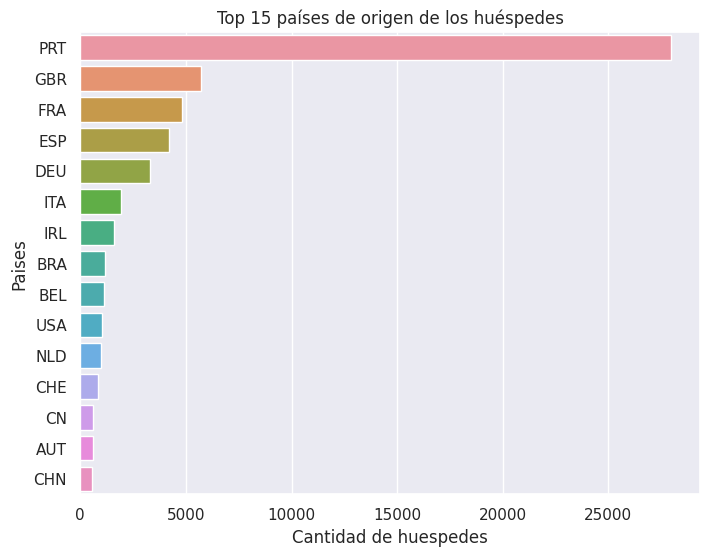

In [547]:
top_countries = df_hotels_train['country'].value_counts().nlargest(15)

top_countries_index = top_countries.index

df_top_countries = df_hotels_train[df_hotels_train['country'].isin(top_countries_index)]

plot = sns.countplot(y='country', data=df_top_countries, order=top_countries_index).set(title = "Top 15 países de origen de los huéspedes", ylabel = "Paises", xlabel = "Cantidad de huespedes")

La mayoria de clientes que efectuaron reservas, provienen de Portugal.

Al ser casi todos los paises, el grafico la distribución se volvia inentendible, por lo tanto decidimos acotarlo con los 15 paises más registrados.

#### --------------------------------------------------------------------------

#### `market_segment`
  - Descripción: Designación del segmento del mercado
  - Tipo de dato: Cualitativas
  - Valores posibles: _ver en código_
  - Frecuencia: _ver en código_ 


In [548]:
#Valores posibles
df_hotels_train['market_segment'].unique()

array(['Online TA', 'Groups', 'Offline TA/TO', 'Direct', 'Complementary',
       'Corporate', 'Aviation', 'Undefined'], dtype=object)

- Direct: La reserva fue hecha directamente con el hotel.
- Corporate : La reserva fue hecha por una empresa.
- Online TA: La reserva se concreto a través de una agencia de viajes activa.
- Offline TA/TO: La reserva fue hecha a través de una agencia de viajes que no se encuentra disponible o un operador turístico.
- Complementary: La reserva fue hecha como complemento de otra reserva previa.
- Groups: La reserva fue hecha como parte de un grupo .

- ###### Frecuencia


In [549]:
round(df_hotels_train['market_segment'].value_counts(normalize=True) * 100, 2)

Online TA        47.27
Offline TA/TO    20.00
Groups           18.65
Direct            9.30
Corporate         4.01
Complementary     0.58
Aviation          0.18
Undefined         0.00
Name: market_segment, dtype: float64

- ###### Distribución


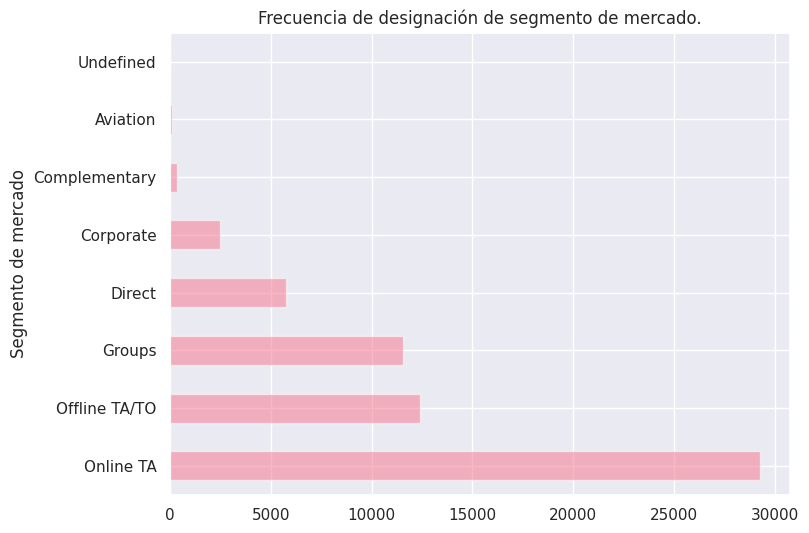

In [550]:
grf=df_hotels_train['market_segment'].value_counts().plot.barh(alpha=0.5, title="Frecuencia de designación de segmento de mercado.",xlabel='Segmento de mercado',ylabel='Segmento de mercado')  


La distribución se reparte entre 3 categorias mayormente: 
1. Online TA (Travel Agents)
2. Offline TA/TO
3. Groups

#### --------------------------------------------------------------------------

#### `distribution_channel`
  - Descripción: Canal de distribución de la reserva
  - Tipo de dato: Cualitativas
  - Valores posibles: _ver en código_
  - Frecuencia: _ver en código_ 


In [551]:
#Valores posibles
df_hotels_train['distribution_channel'].unique()

array(['TA/TO', 'Direct', 'Corporate', 'GDS', 'Undefined'], dtype=object)

- ###### Frecuencia


In [552]:
round(df_hotels_train['distribution_channel'].value_counts(normalize=True) * 100, 2)

TA/TO        83.74
Direct       10.98
Corporate     5.12
GDS           0.14
Undefined     0.01
Name: distribution_channel, dtype: float64

- ###### Distribución


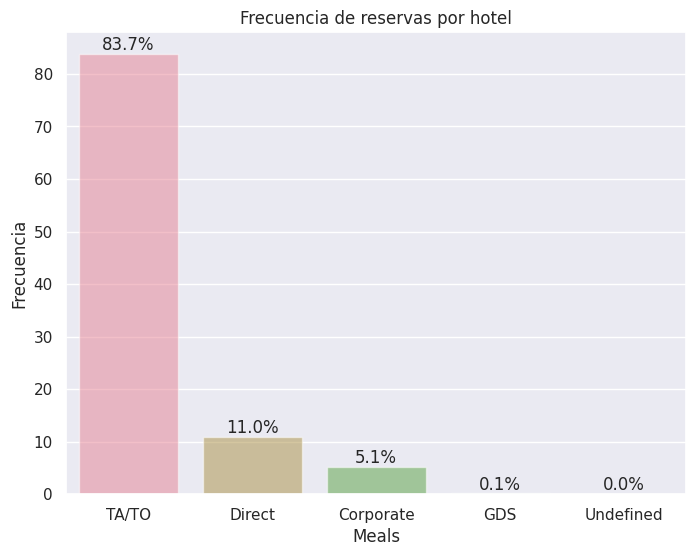

In [553]:
showBarPlot('distribution_channel', "Frecuencia de reservas por hotel", x_label= 'Meals', y_label="Frecuencia", showPercentage = True)

La mayoria de reservas se hicieron mediante el canal de distribución de TA/TO

#### --------------------------------------------------------------------------

#### `is_repeated_guest`
  - Descripción: Indica si el usuario ya hizo una reserva anteriormente
  - Tipo de dato: Cualitativa
  - Valores posibles: 0 y 1
  - Frecuencia: _ver en código_ 



- ###### Frecuencia


In [554]:
round(df_hotels_train['is_repeated_guest'].value_counts(normalize=True) * 100, 2)

0    97.2
1     2.8
Name: is_repeated_guest, dtype: float64

- ###### Distribución


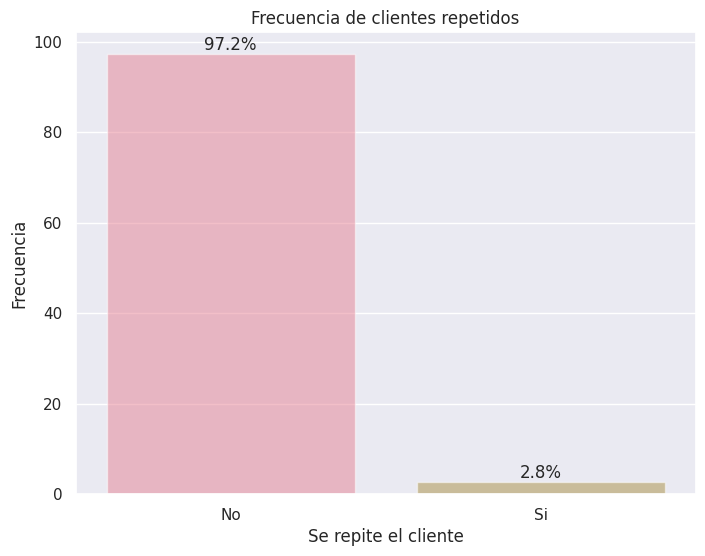

In [555]:
ds_hotels_reemplazo_valores = df_hotels_train.copy()

ds_hotels_reemplazo_valores.loc[ds_hotels_reemplazo_valores.loc[:,"is_repeated_guest"]==1,"is_repeated_guest"] = "Si"
ds_hotels_reemplazo_valores.loc[ds_hotels_reemplazo_valores.loc[:,"is_repeated_guest"]==0,"is_repeated_guest"] = "No"


showBarPlot('is_repeated_guest', "Frecuencia de clientes repetidos", x_label= 'Se repite el cliente', y_label="Frecuencia", showPercentage = True, df_hotels = ds_hotels_reemplazo_valores)

Para la mayoria de los clientes, es la primera vez que efectuan una reserva

#### `previous_cancellations`
  - Descripción: Indica cuantas cancelaciones hizo anteriormente
  - Tipo de dato: Cuantitativa
  - Medidas de resumen: _ver en código_
  - Distribución: _ver en código_

  - ###### Medidas

In [556]:
round(df_hotels_train['previous_cancellations'].describe(), 2)

count    61913.00
mean         0.11
std          0.99
min          0.00
25%          0.00
50%          0.00
75%          0.00
max         26.00
Name: previous_cancellations, dtype: float64

  - ###### Distribución

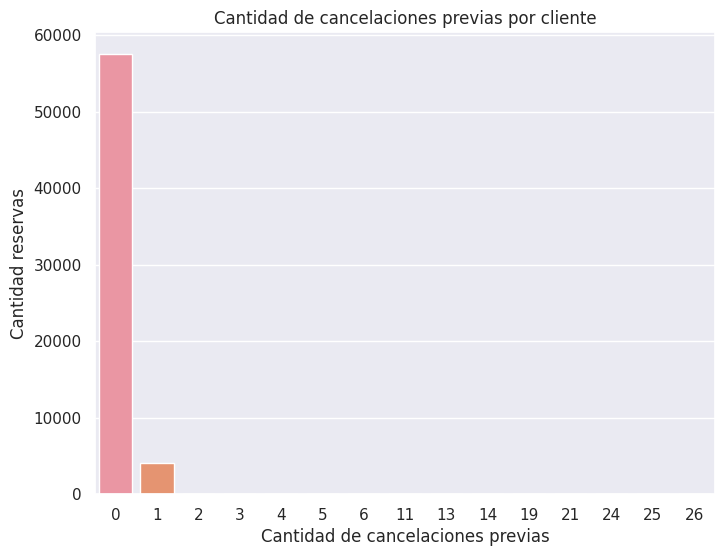

In [557]:
plot = sns.countplot(x='previous_cancellations', data=df_hotels_train).set(title = "Cantidad de cancelaciones previas por cliente", ylabel = "Cantidad reservas", xlabel = "Cantidad de cancelaciones previas")

La mayoria de clientes no registran haber cancelado anteriormente una reserva

#### --------------------------------------------------------------------------

#### `previous_bookings_not_canceled`
  - Descripción: Indica cuantas reservas completo
  - Tipo de dato: Cuantitativa
  - Medidas de resumen: _ver en código_
  - Distribución: _ver en código_

  - ###### Medidas

In [558]:
round(df_hotels_train['previous_bookings_not_canceled'].describe(), 2)

count    61913.00
mean         0.12
std          1.40
min          0.00
25%          0.00
50%          0.00
75%          0.00
max         70.00
Name: previous_bookings_not_canceled, dtype: float64

  - ###### Distribución

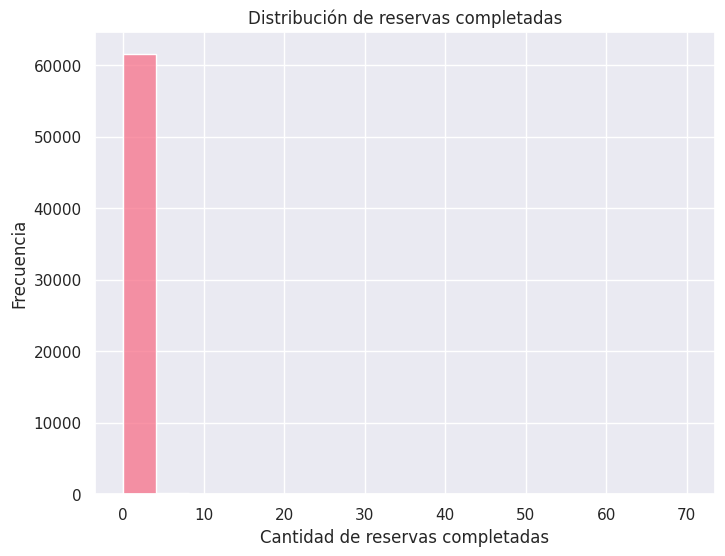

In [559]:
histplot = sns.histplot(data = df_hotels_train, x = "previous_bookings_not_canceled").set(title = "Distribución de reservas completadas", ylabel = "Frecuencia", xlabel = "Cantidad de reservas completadas")

La mayoria de los clientes no cancelaron sus reservas

#### --------------------------------------------------------------------------

#### `reserved_room_type`
  - Descripción: Tipo de habitacion reservada
  - Tipo de dato: Cualitativas
  - Valores posibles: _ver en código_
  - Frecuencia: _ver en código_ 


In [560]:
#Valores posibles
df_hotels_train['reserved_room_type'].unique()

array(['D', 'A', 'F', 'E', 'G', 'B', 'C', 'H', 'P', 'L'], dtype=object)

- ###### Frecuencia


In [561]:
round(df_hotels_train['reserved_room_type'].value_counts(normalize=True) * 100, 2)

A    72.90
D    15.48
E     5.25
F     2.34
G     1.76
B     0.94
C     0.78
H     0.54
P     0.01
L     0.00
Name: reserved_room_type, dtype: float64

- ###### Distribución


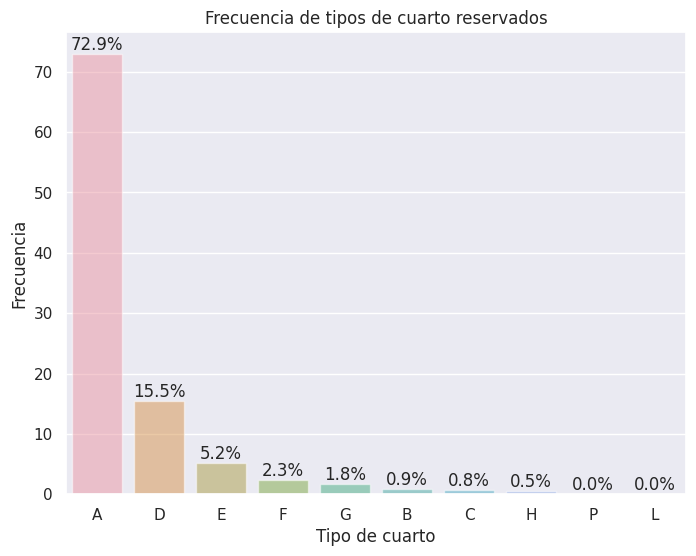

In [562]:
showBarPlot('reserved_room_type', "Frecuencia de tipos de cuarto reservados", x_label= 'Tipo de cuarto', y_label="Frecuencia", showPercentage = True)

El cuarto A es el cuarto más solicitado.

#### --------------------------------------------------------------------------

#### `assigned_room_type`
  - Descripción: Tipo de habitacion asignada
  - Tipo de dato: Cualitativas
  - Valores posibles: _ver en código_
  - Frecuencia: _ver en código_ 


In [563]:
#Valores posibles
df_hotels_train['assigned_room_type'].unique()

array(['D', 'A', 'F', 'E', 'H', 'C', 'G', 'B', 'I', 'K', 'P', 'L'],
      dtype=object)

- ###### Frecuencia


In [564]:
round(df_hotels_train['assigned_room_type'].value_counts(normalize=True) * 100, 2)

A    64.62
D    19.69
E     6.10
F     2.94
G     2.06
C     1.82
B     1.71
H     0.62
I     0.23
K     0.19
P     0.01
L     0.00
Name: assigned_room_type, dtype: float64

- ###### Distribución


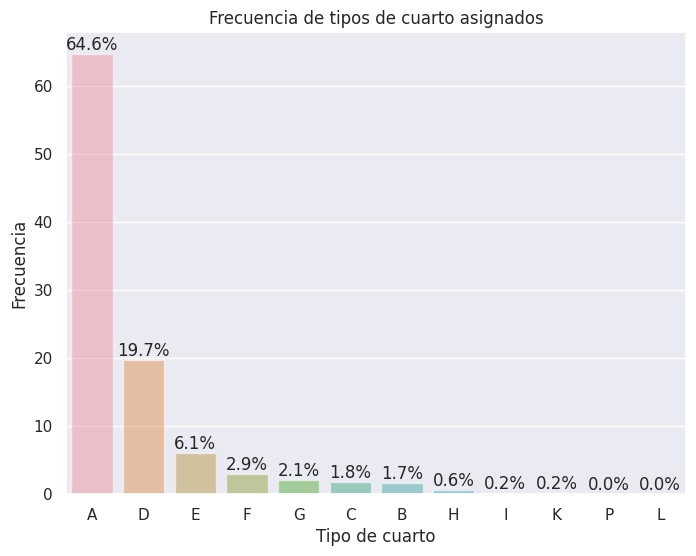

In [565]:
showBarPlot('assigned_room_type', "Frecuencia de tipos de cuarto asignados", x_label= 'Tipo de cuarto', y_label="Frecuencia", showPercentage = True)

El cuarto A es el más asignado. Podemos pensar que puede ser el cuarto standar y el más economico. Ya que los cuartos I, K, P y L son los menos asignados y solicitados

#### --------------------------------------------------------------------------

#### `booking_changes`
  - Descripción: Número de cambios hechos en la reserva
  - Tipo de dato: Cuantitativa
  - Medidas de resumen: _ver en código_
  - Distribución: _ver en código_

  - ###### Medidas

In [566]:
round(df_hotels_train['booking_changes'].describe(), 2)

count    61913.00
mean         0.20
std          0.61
min          0.00
25%          0.00
50%          0.00
75%          0.00
max         17.00
Name: booking_changes, dtype: float64

  - ###### Distribución

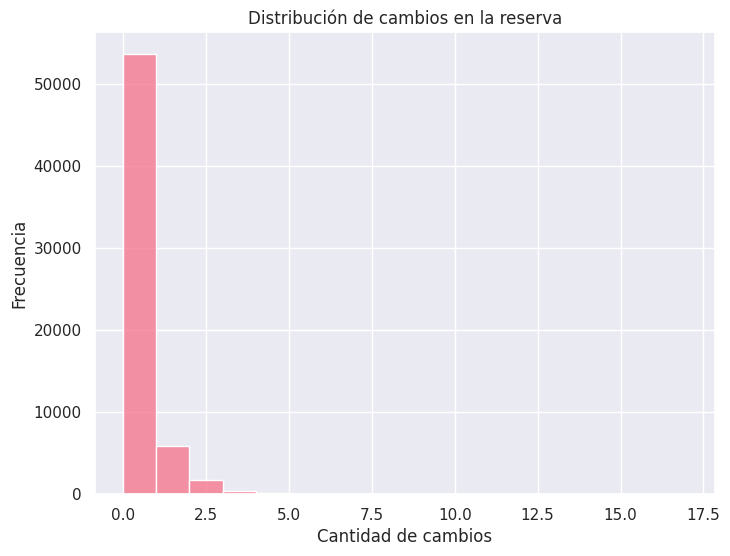

In [567]:
histplot = sns.histplot(data = df_hotels_train, x = "booking_changes").set(title = "Distribución de cambios en la reserva", ylabel = "Frecuencia", xlabel = "Cantidad de cambios")

La mayoria de clientes no efecutaron cambios en la reserva.

#### --------------------------------------------------------------------------

#### `deposit_type`
  - Descripción: Tipo de depósito que hizo el huésped para garantizar su reserva
  - Tipo de dato: Cualitativa
  - Valores posibles: _ver en codigo_ 
  - Frecuencia: _ver en codigo_ 


In [568]:
#Frecuencia
round(df_hotels_train['deposit_type'].value_counts(normalize=True) * 100, 2)

No Deposit    83.48
Non Refund    16.39
Refundable     0.13
Name: deposit_type, dtype: float64

In [569]:
#Valores posibles
df_hotels_train['deposit_type'].unique()

array(['No Deposit', 'Non Refund', 'Refundable'], dtype=object)

- ###### Distribución


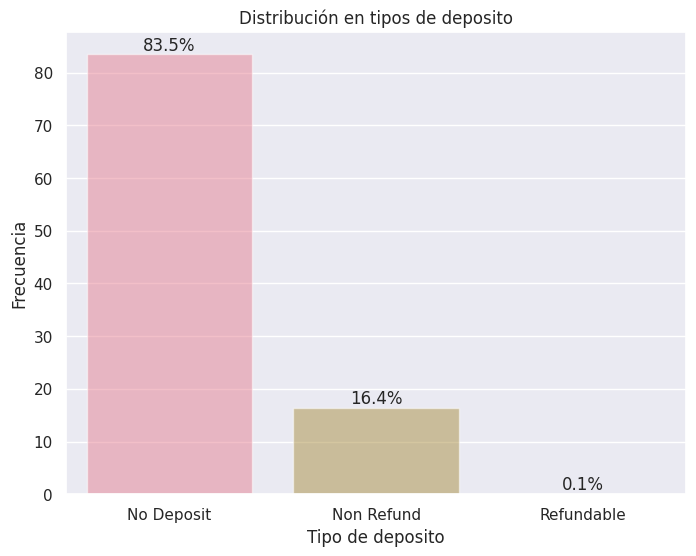

In [570]:
showBarPlot('deposit_type', "Distribución en tipos de deposito", x_label= 'Tipo de deposito', y_label="Frecuencia", showPercentage = True)

La mayoria de los clientes no efectuaron ningun deposito para garantizar la reserva.

#### --------------------------------------------------------------------------

#### `agent`
  - Descripción: Identificador del agente de la reserva
  - Tipo de dato: Cualitativas
  - Valores posibles: _ver en código_
  - Frecuencia: _ver en código_ 


In [571]:
#Frecuencia
round(df_hotels_train['agent'].value_counts(normalize=True) * 100, 2)

9.0      31.48
240.0    13.67
1.0       8.19
14.0      3.15
6.0       3.03
         ...  
420.0     0.00
352.0     0.00
450.0     0.00
283.0     0.00
25.0      0.00
Name: agent, Length: 296, dtype: float64

In [572]:
#Valores posibles
df_hotels_train['agent'].unique()

array([  9.,  nan, 154.,  20., 314., 240.,  58., 250.,  86., 229.,   1.,
        33.,   8.,   3., 236., 177.,  38.,  39., 170., 410.,  85.,  26.,
        96.,  14., 134.,  56., 234., 468., 254., 147.,  34., 138.,  40.,
        29., 315.,  37., 195., 326.,  35., 208.,  22.,  17., 296.,  28.,
         6.,  19.,  98.,  83., 298.,  27., 378., 484.,   7.,  16.,  21.,
       175., 171., 243.,  41.,  45.,  11., 157., 273.,  12., 387., 368.,
       434.,   5.,  36., 436., 405., 191., 257.,  95.,  15.,  31., 440.,
        50., 241.,   4.,  67.,  63., 168.,  44., 261., 281.,  94., 336.,
        30., 420., 104., 121., 464., 196., 142., 151., 242., 119., 339.,
       310., 531., 305.,   2.,  53.,  64., 248., 313., 364., 286., 459.,
       133., 132., 245., 143.,  52., 155., 251., 223., 156., 159., 185.,
       323.,  13., 330., 359., 527., 103.,  68., 174.,  82.,  42., 256.,
       483., 146.,  89., 252., 220.,  88., 303., 181., 152.,  24., 394.,
        75., 306., 183.,  69.,  10., 184., 149., 16

#### --------------------------------------------------------------------------

#### `company`
  - Descripción: Identificador de la compañia de la reserva
  - Tipo de dato: Cualitativas
  - Valores posibles: _ver en código_
  - Frecuencia: _ver en código_ 


In [573]:
#Frecuencia
round(df_hotels_train['company'].value_counts(normalize=True) * 100, 2)

40.0     12.37
223.0    11.55
67.0      5.36
45.0      3.74
153.0     3.36
         ...  
305.0     0.03
275.0     0.03
461.0     0.03
220.0     0.03
160.0     0.03
Name: company, Length: 276, dtype: float64

In [574]:
#Valores posibles
df_hotels_train['company'].unique()

array([ nan, 223., 512., 218., 233., 268., 385.,  88., 154.,  51., 281.,
       202.,  67., 405.,  45., 329.,  46., 197., 137., 366., 174.,  40.,
       144., 227.,  86., 159., 477., 308.,  43., 219.,  68., 407.,  81.,
       465., 343., 466., 353., 424., 485.,  38.,  94., 153.,  72.,  20.,
        47., 286., 195., 358., 277., 355.,  12., 498., 278.,  62., 393.,
       238., 242., 143., 135., 331., 400., 342., 110., 313.,  78., 348.,
       209., 452.,  99., 250., 118., 507., 397., 321., 113., 167.,   9.,
       204., 280.,  83., 203., 333., 365., 186., 324., 169., 496.,  31.,
       382., 270.,  84., 245., 274., 215., 418., 525., 290.,  39.,  14.,
       150., 251., 292.,  91., 230., 521., 320., 334., 408., 207., 122.,
       178.,  82., 388., 360., 148., 183.,  22., 435., 420., 523., 307.,
       319.,  49., 421., 380.,  54., 221., 282.,  48., 200., 126., 216.,
       338., 379., 356., 461., 543., 220., 371., 105., 311., 346., 269.,
       168., 372., 399., 120.,  37., 115., 291., 12

#### --------------------------------------------------------------------------

#### `days_in_waiting_list`
  - Descripción: Número de días que la reserva estuvo en lista de espera antes de ser confirmada al cliente
  - Tipo de dato: Cuantitativa
  - Medidas de resumen: _ver en código_
  - Distribución: _ver en código_

In [575]:
#Medidas
round(df_hotels_train['days_in_waiting_list'].describe(), 2)

count    61913.00
mean         2.64
std         18.62
min          0.00
25%          0.00
50%          0.00
75%          0.00
max        391.00
Name: days_in_waiting_list, dtype: float64

  - ###### Distribución

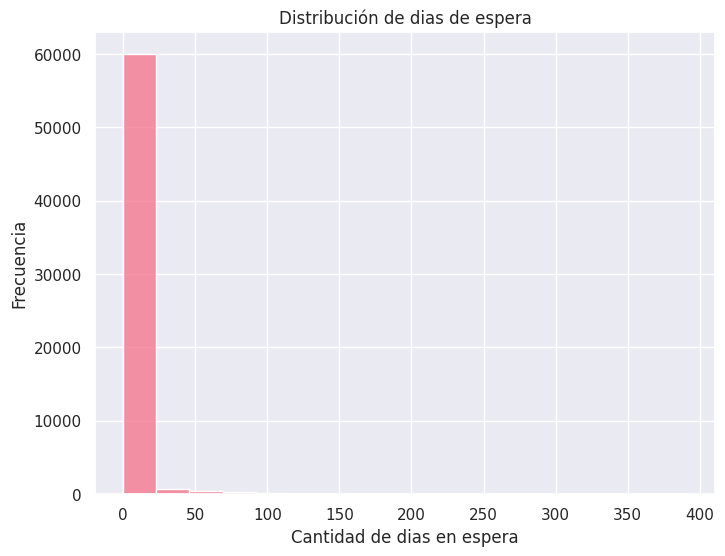

In [576]:
histplot = sns.histplot(data = df_hotels_train, x = "days_in_waiting_list").set(title = "Distribución de dias de espera", ylabel = "Frecuencia", xlabel = "Cantidad de dias en espera")

Podemos observar que, el tiempo promedio de espera, es de 1 a 25 días.

#### --------------------------------------------------------------------------

#### `customer_type`
  - Descripción: Tipo de usuario
  - Tipo de dato: Cualitativas
  - Valores posibles: _ver en código_
  - Frecuencia: _ver en código_ 


In [577]:
#Frecuencia
round(df_hotels_train['customer_type'].value_counts(normalize=True) * 100, 2)

Transient          76.64
Transient-Party    19.65
Contract            3.28
Group               0.42
Name: customer_type, dtype: float64

In [578]:
#Valores posibles
df_hotels_train['customer_type'].unique()

array(['Transient', 'Transient-Party', 'Contract', 'Group'], dtype=object)

- ###### Distribución


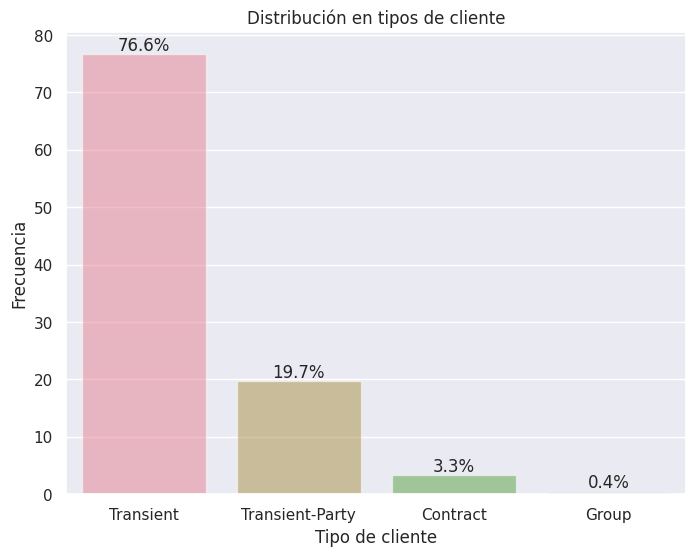

In [579]:
showBarPlot('customer_type', "Distribución en tipos de cliente", x_label= 'Tipo de cliente', y_label="Frecuencia", showPercentage = True)

La mayoría de los clientes hicieron una reserva individual y no forman parte de ningún grupo ni están asociados con ninguna otra reserva

#### --------------------------------------------------------------------------

#### `adr`
  - Descripción: Precio promedio por día
  - Tipo de dato: Cuantitativa
  - Medidas de resumen: _ver código_
  - Distribución: _ver código_


In [580]:
#Medidas
round(df_hotels_train['adr'].describe(), 2)

count    61913.00
mean       102.38
std         47.76
min         -6.38
25%         70.00
50%         95.00
75%        126.00
max        510.00
Name: adr, dtype: float64

  - ###### Distribución

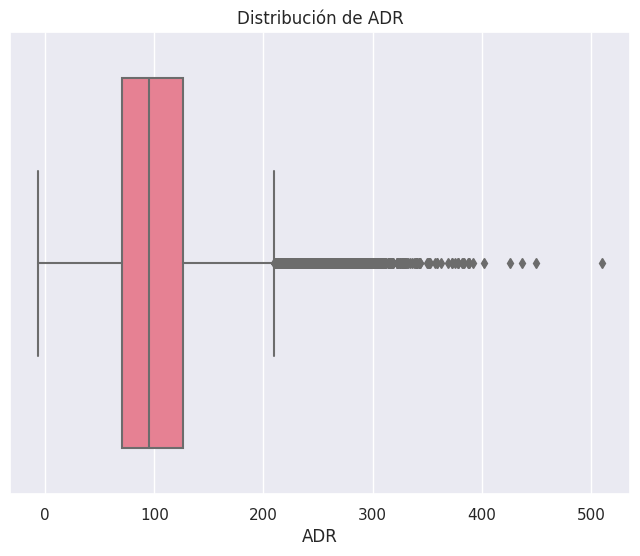

In [581]:
histplot = sns.boxplot(data = df_hotels_train, x = "adr").set(title = "Distribución de ADR", xlabel = "ADR")

El promedio de precio por día es de alrededor 100 usd

#### --------------------------------------------------------------------------

#### `required_car_parking_spaces`
  - Descripción: Cantidad de estacionamientos pedidos por el usuario
  - Tipo de dato: Cuantitativa
  - Medidas de resumen: _ver código_
  - Distribución: _ver código_


In [582]:
#Medidas
round(df_hotels_train['required_car_parking_spaces'].describe(), 2)

count    61913.00
mean         0.05
std          0.22
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          8.00
Name: required_car_parking_spaces, dtype: float64

  - ###### Distribución

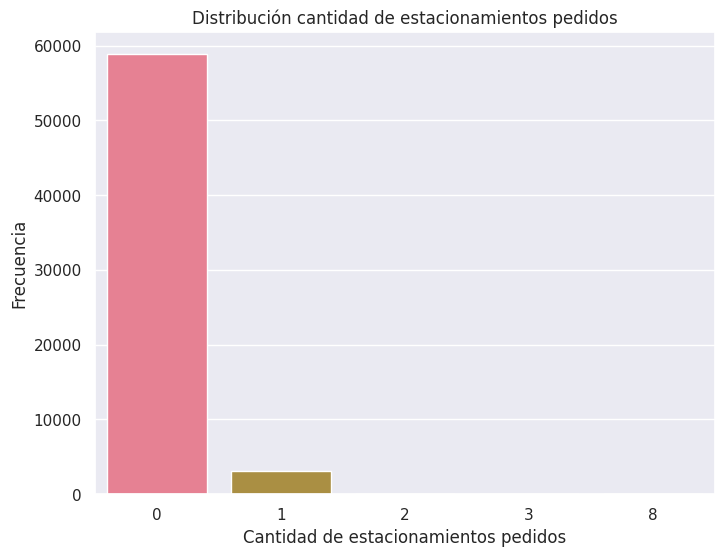

In [583]:
histplot = sns.countplot(data = df_hotels_train, x = "required_car_parking_spaces").set(title = "Distribución cantidad de estacionamientos pedidos", ylabel = "Frecuencia", xlabel = "Cantidad de estacionamientos pedidos")

La mayoria de los clientes no pidieron espacios para el estacionamiento

#### --------------------------------------------------------------------------

#### `total_of_special_requests`
  - Descripción: Cantidad de pedidos especiales del usario
  - Tipo de dato: Cuantitativa
  - Medidas de resumen: _ver código_
  - Distribución: _ver código_


In [584]:
#Medidas
round(df_hotels_train['total_of_special_requests'].describe(), 2)

count    61913.00
mean         0.52
std          0.78
min          0.00
25%          0.00
50%          0.00
75%          1.00
max          5.00
Name: total_of_special_requests, dtype: float64

  - ###### Distribución

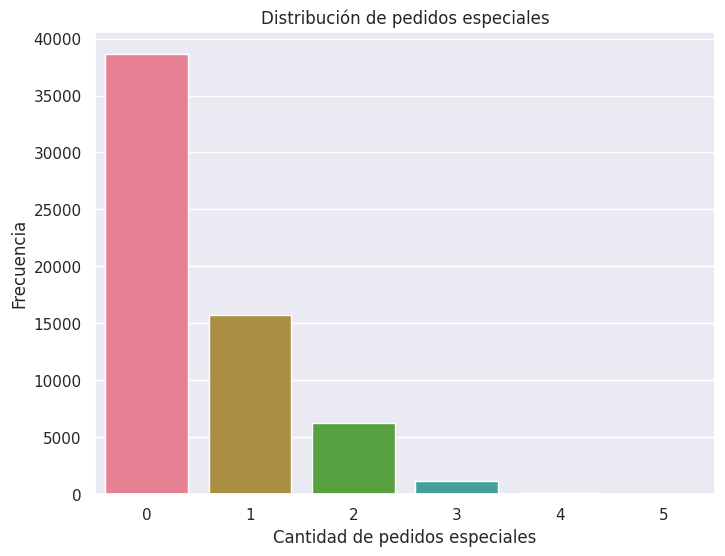

In [585]:
histplot = sns.countplot(data = df_hotels_train, x = "total_of_special_requests").set(title = "Distribución de pedidos especiales", ylabel = "Frecuencia", xlabel = "Cantidad de pedidos especiales")

La mayoria de los clientes no registraron pedidos especiales para su reserva

#### --------------------------------------------------------------------------

#### `reservation_status_date`
  - Descripción: Fecha de la ultima actualizacion del estado
  - Tipo de dato: Cuantitativa
  - Medidas de resumen: _ver codigo_


In [586]:
#Medidas
df_hotels_train['reservation_status_date'].describe()

count          61913
unique           915
top       2015-10-21
freq            1013
Name: reservation_status_date, dtype: object

#### --------------------------------------------------------------------------

#### `id`
  - Descripción: Identificador de la reserva
  - Tipo de dato: Cuantitativa
  - Medidas de resumen: _ver codigo_


In [587]:
#Medidas
df_hotels_train['id'].describe()

count                                    61913
unique                                   61913
top       7aa4cc6b-b92c-4061-b21d-4f9e0cac4689
freq                                         1
Name: id, dtype: object

#### --------------------------------------------------------------------------

#### `is_canceled`
  - Descripción: Identificador de la reserva
  - Tipo de dato: Cualitativas
  - Valores posibles: _ver en código_
  - Frecuencia: _ver en código_ 


In [588]:
#Valores posibles
df_hotels_train['is_canceled'].unique()

array([1, 0])

- ###### Frecuencia


In [589]:
round(df_hotels_train['is_canceled'].value_counts(normalize=True) * 100, 2)

0    50.03
1    49.97
Name: is_canceled, dtype: float64

- ###### Distribución


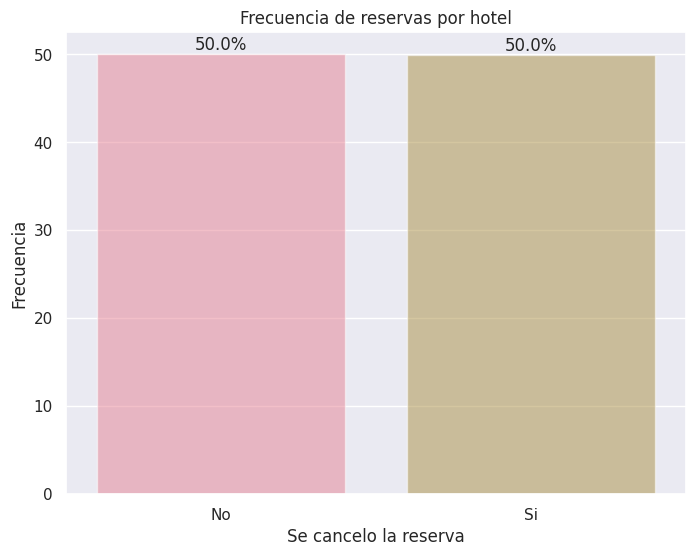

In [590]:
ds_hotels_reemplazo_valores = df_hotels_train.copy()

ds_hotels_reemplazo_valores.loc[ds_hotels_reemplazo_valores.loc[:,"is_canceled"]==1,"is_canceled"] = "Si"
ds_hotels_reemplazo_valores.loc[ds_hotels_reemplazo_valores.loc[:,"is_canceled"]==0,"is_canceled"] = "No"


showBarPlot('is_canceled', "Frecuencia de reservas por hotel", x_label= 'Se cancelo la reserva', y_label="Frecuencia", showPercentage = True, df_hotels = ds_hotels_reemplazo_valores)

## Variables irrelevantes

Analizando el dataset, podemos encontrar las siguientes columnas que no aportan una información relevante para el análisis de la variable **target**.

Columnas:
- `agent`: Es un identificador, no provee información importante
- `company`: Es un identificador, no provee información importante
- `reservation_status`: Por pedido de los profesores, no se tendrá en cuenta
- `reservation_status_date`: Como está relacionada a la variable anterior, tampoco se tendrá en cuenta.

La columna `id` tambien es un identificador, pero en este caso no lo vamos a eliminar, ya que es necesario para la competencia _Kaggle_.

Al hacer dicho analisis, procedemos a eliminar dichas columnas del dataset de training y test

In [592]:
columns = ['agent', 'company']
df_hotels_train.drop(columns, inplace=True, axis="columns")
df_hotels_test.drop(columns, inplace=True, axis="columns")

In [593]:
df_hotels_train.columns.tolist()

['hotel',
 'lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'reserved_room_type',
 'assigned_room_type',
 'booking_changes',
 'deposit_type',
 'days_in_waiting_list',
 'customer_type',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'reservation_status_date',
 'id',
 'is_canceled']

## Correlaciones

A continuación veremos un grafico que representara la correlación entre las variables

<Axes: >

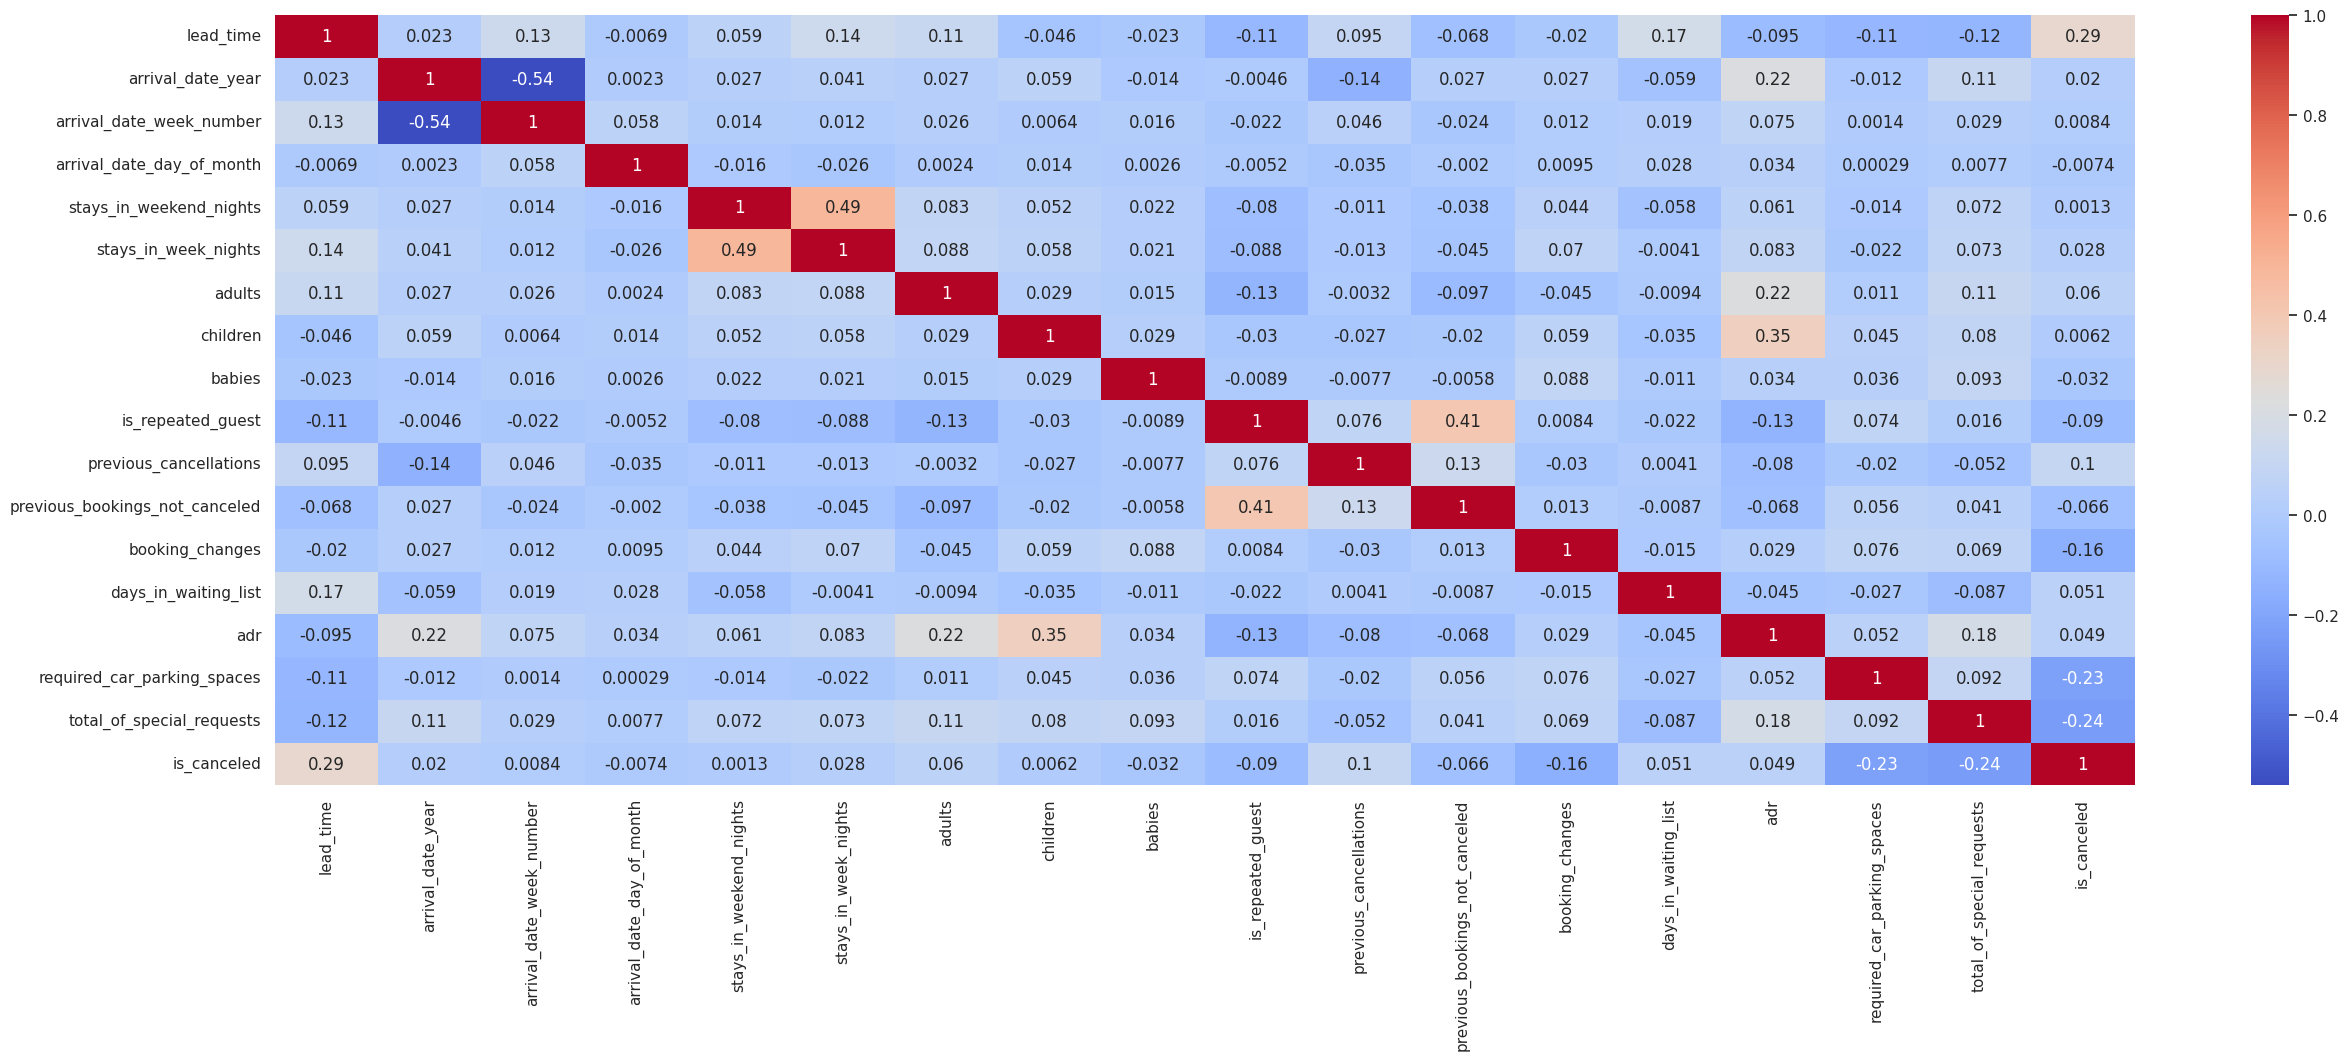

In [595]:
plt.figure(figsize = (30,10))
sns.heatmap(df_hotels_train.corr(), annot=True, cmap='coolwarm')

Vamos a analizar las correlaciones entre las variables sin tener encuenta nuestro **target**.
- `lead_time`: 
  - Correlación negativa moderada leve con `is_repeated_guest` (-0.11)
  - Correlación negativa moderada leve con `required_car_parking_spaces` (-0.11)
  - Correlación negativa moderada leve con `total_of_special_requests` (-0.12)
- `arrival_date_year`: 
  - correlación negativa significativa con `arrival_date_week_number` (-0.54)
  - Correlación positiva leve con `adr` (0.22)
  - Correlación negativa moderada leve con `previous_cancelations` (-0.14)
- `arrival_date_week_number`:
  - Correlación positiva leve con `lead_time`



  Continuar análisis.

Podemos observar que, las variables cualitativas, no se encuentran representadas en el anterior _heapmap_. Esto es porque la matriz de correlacion que calcula pandas, solo es para variables cuantitativas. Por lo tanto, para el analisis de las correllaciones de las variables **cualitativas**, utilizaremos la medida de _V de cramer_.

> La V de Cramer es una medida de asociación estadística utilizada para analizar la relación entre dos variables categóricas. Es una medida de la fuerza de la relación entre las dos variables, que varía entre 0 (no hay asociación) y 1 (asociación perfecta). Se calcula a partir de la tabla de contingencia de las dos variables, que muestra la frecuencia conjunta de las distintas combinaciones de categorías de ambas variables. 

[Informacion sobre V de cramer](https://en.m.wikipedia.org/wiki/Cram%C3%A9r%27s_V)

Para poder lograr un analaisis mas preciso, vamos a crear una nueva columna que representa el mes de llegada

In [ ]:
df_hotels_train['arrival_date_month'] = df_hotels_train.apply(lambda column: weekNumberToMonth(column['arrival_date_year'], column['arrival_date_week_number']), axis = 1)
df_hotels_test['arrival_date_month'] = df_hotels_test.apply(lambda column: weekNumberToMonth(column['arrival_date_year'], column['arrival_date_week_number']), axis = 1)

Creamos un heapmap con una matriz de correlación utilizando V de cramer

<Axes: >

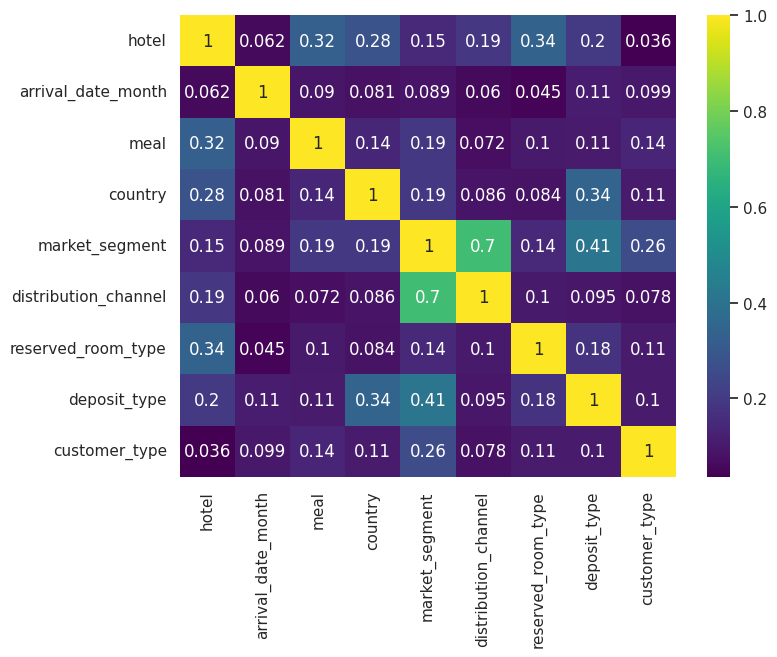

In [609]:
variables_cualitativas = ['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type']

corr_matrix = np.zeros((len(variables_cualitativas), len(variables_cualitativas)))

for i, var1 in enumerate(variables_cualitativas):
    for j, var2 in enumerate(variables_cualitativas):
        corr_matrix[i, j] = cramers_v(df_hotels_train[var1], df_hotels_train[var2])

sns.heatmap(corr_matrix, annot=True, xticklabels=variables_cualitativas, yticklabels=variables_cualitativas, cmap= "viridis")

## Visualización adicional de datos

Cosas a hacer:

Realizar un resumen de cada grafico

Graficos a implementar:
- is_canceled con lo del estacionamiento
- is_canceled con los pedidos especiales

Analizar si conviene separar por hotel

### Análisis de variables con la variables **target**

#### hotel con cancelacion

Representamos en un grafico de torta el porcentaje del total de cancelaciones por hotel.

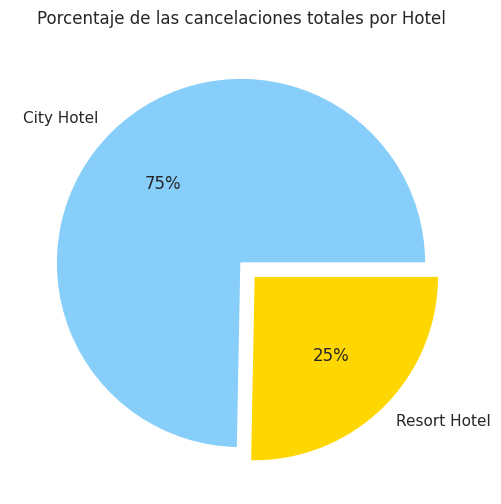

In [ ]:
df_filtrado = df_hotels_train[df_hotels_train['is_canceled'] == 1]
data = df_filtrado['hotel'].value_counts().tolist()
labels = df_hotels_train['hotel'].value_counts().index.tolist()
colors = ['lightskyblue','gold']
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%', explode=(0, 0.1))
plt.title(label = "Porcentaje de las cancelaciones totales por Hotel")
plt.show()

En el análisis de distribución de la variable `hotel` pudimos observar que el hotel _City_ es el más frecuente. Con éste gráfico observamos que, no solamente es el hotel más solicitado, sino que tambien es el que tiene una tasa de cancelación mayor al del hotel _Resort_.

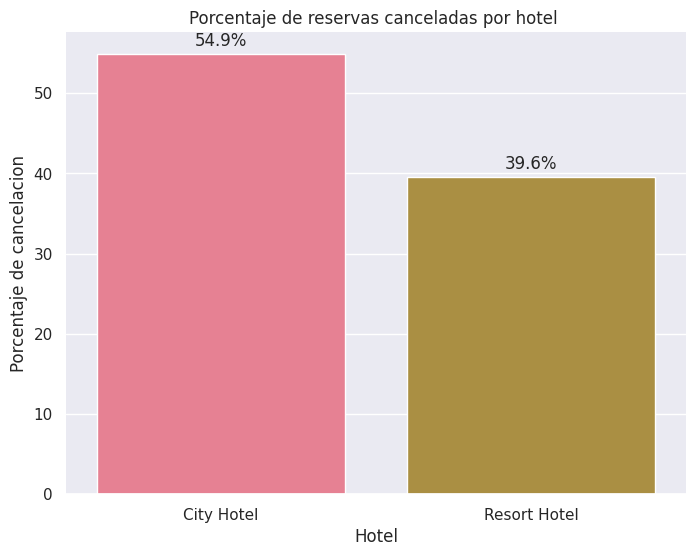

In [ ]:
hotel_cancel_perc = df_hotels_train.groupby(['hotel'])['is_canceled'].mean() * 100


ax = sns.barplot(x=hotel_cancel_perc.index, y=hotel_cancel_perc.values)
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(8,6)})
sns.set_palette("husl")
sns.despine(left=True)


for i, v in enumerate(hotel_cancel_perc.values):
    ax.text(i, v + 1, f"{v:.1f}%", ha='center')


plt.title('Porcentaje de reservas canceladas por hotel ')
plt.xlabel('Hotel')
plt.ylabel('Porcentaje de cancelacion')

plt.show()

Sabemos que el hotel _City_ posee 42101 reservas, pero con éste gráfico, podemos observar que de 42101 reservas, el 54,9% son canceladas, lo cual equivale a unas 23114 reservas son canceladas. 

En cambio con el hotel _Resort_, que posee 19812 reservas, solamente son canceladas 7846 reservas.

#### lead_time con is_canceled

<Axes: xlabel='is_canceled', ylabel='lead_time'>

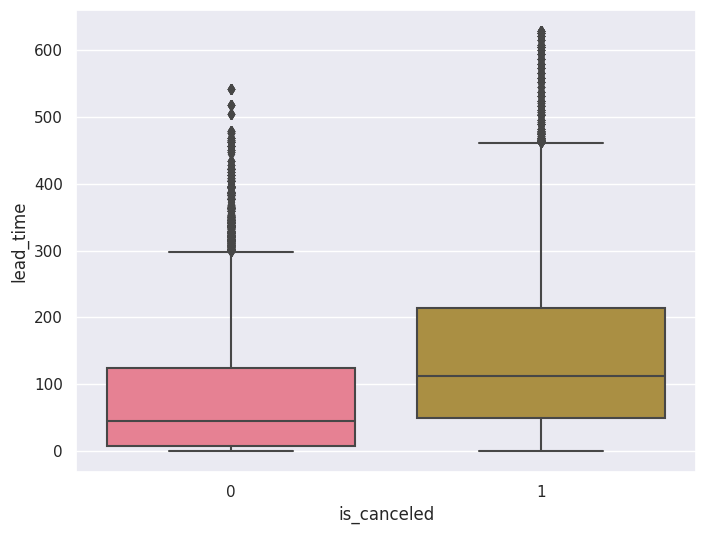

In [ ]:
sns.boxplot(df_hotels_train, y = 'lead_time', x = 'is_canceled')

[Text(0, 0.5, '')]

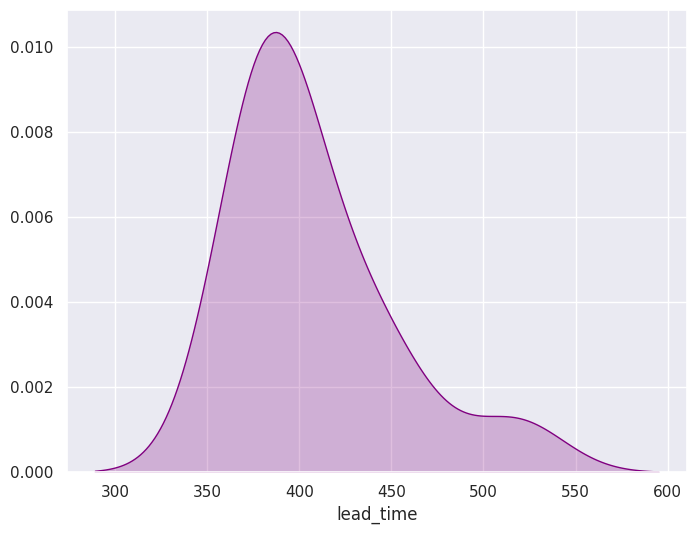

In [ ]:
cancelas_por_lead_time = df_hotels_train.groupby(['lead_time'])['is_canceled'].agg('sum').reset_index()
ax = sns.kdeplot(cancelas_por_lead_time[cancelas_por_lead_time['is_canceled'] == 1]['lead_time'], color='purple', fill=True)
ax.set(ylabel=None)

<Axes: xlabel='is_canceled', ylabel='lead_time'>

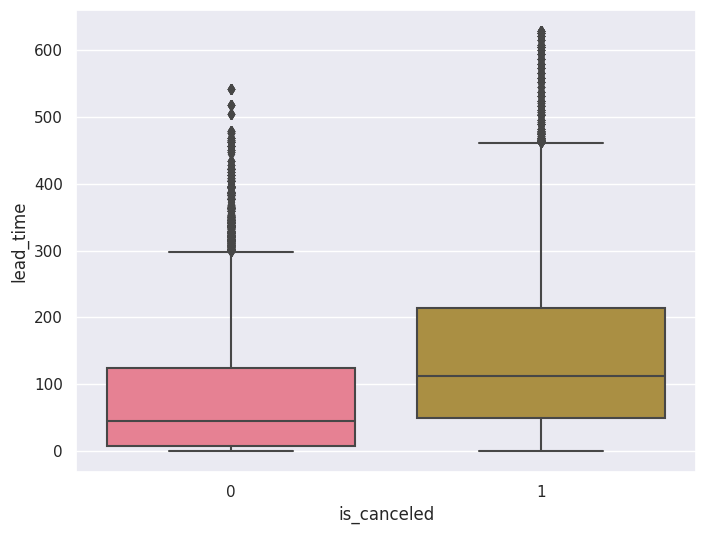

In [ ]:
sns.boxplot(df_hotels_train, y = 'lead_time', x = 'is_canceled')

[Text(0, 0.5, '')]

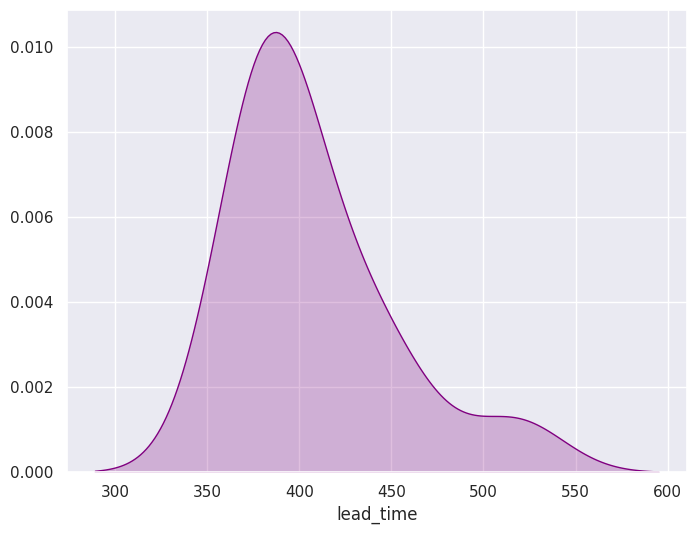

In [ ]:
cancelas_por_lead_time = df_hotels_train.groupby(['lead_time'])['is_canceled'].agg('sum').reset_index()
ax = sns.kdeplot(cancelas_por_lead_time[cancelas_por_lead_time['is_canceled'] == 1]['lead_time'], color='purple', fill=True)
ax.set(ylabel=None)

### Análisis entre varables (sin **target**)

#### Analsis de reserved_room_type con adr

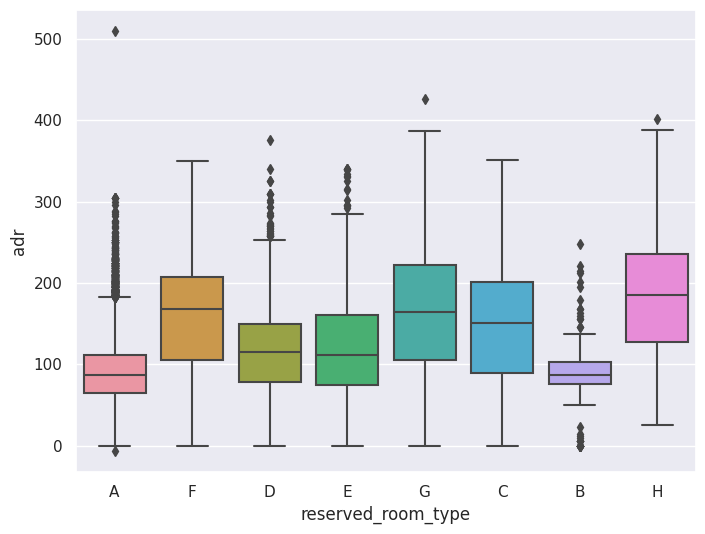

In [602]:
plot = sns.boxplot(x='reserved_room_type',y = 'adr', data = df_hotels_train[df_hotels_train['is_canceled'] == 0])

En los analisis previos, pudimos observar que la habitación **A** era la más solicitada y designada. Gracias a este grafico, podemos concretar que dicha habitación es la más economica. Tambien se puede apreciar que la habitación **H** es la más costosa, lo cual explicaria su baja tasa de reservación.

#### Analsis de evolucion del adr por mes de cada hotel

In [604]:
df_hotel_resort = df_hotels_train[(df_hotels_train['hotel'] == "Resort Hotel" )& (df_hotels_train['is_canceled'] == 0)]
df_hotel_city = df_hotels_train[(df_hotels_train['hotel'] == "City Hotel") & (df_hotels_train['is_canceled'] == 0)]

resort_month = df_hotel_resort.groupby(['arrival_date_month'])['adr'].mean().reset_index()
city_month = df_hotel_city.groupby(['arrival_date_month'])['adr'].mean().reset_index()

df_hotel_adr_merge = resort_month.merge(city_month, on='arrival_date_month')

In [605]:
df_hotel_adr_merge.rename(columns= {'adr_x': 'adr_city', 'adr_y': 'adr_resort'}, inplace=True)
sortByMonth(df_hotel_adr_merge)
df_hotel_adr_merge

,arrival_date_month,adr_city,adr_resort
4,Jan,63.973095,89.582663
3,Feb,54.175079,86.253082
7,Mar,58.313074,91.118516
0,Apr,74.959437,110.181503
8,May,78.679810,118.729753
6,Jun,107.220655,115.247200
5,Jul,149.949432,118.327988
1,Aug,179.359031,116.578842
11,Sep,104.719289,111.331619
10,Oct,65.981586,105.444541


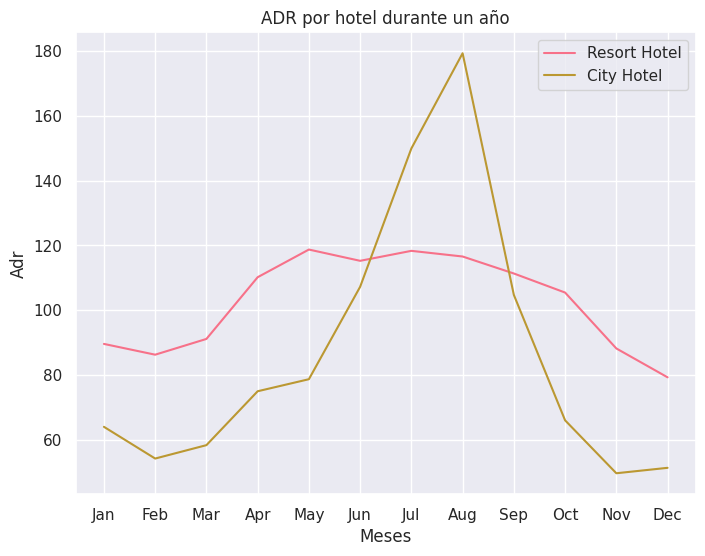

In [610]:
sns.lineplot(df_hotel_adr_merge, x="arrival_date_month", y="adr_resort", label="Resort Hotel")
sns.lineplot(df_hotel_adr_merge, x="arrival_date_month", y="adr_city", label="City Hotel")
plt.legend()
plt.xlabel("Meses")
plt.ylabel("Adr")
plt.title("ADR por hotel durante un año")
plt.show()

Anteriormente pudimos observar que, el tiempo en donde se hacen la mayoria de las reservas, es entre Julio y Agosto. El hotel _City_ en temporada alta de demanda, recurre a aumentar los precios de las reservas, lo cual puede explicar el porqué tiene una tasa de cancelación alta.
Por otro lado, el hotel _Resort_, no aumenta el precio en temporada alta, por lo tanto puede explicar por qué posee menos cancelaciones que el hotel _City_.

#### Analsis de cancelaciones de market_segment con distribution_channel

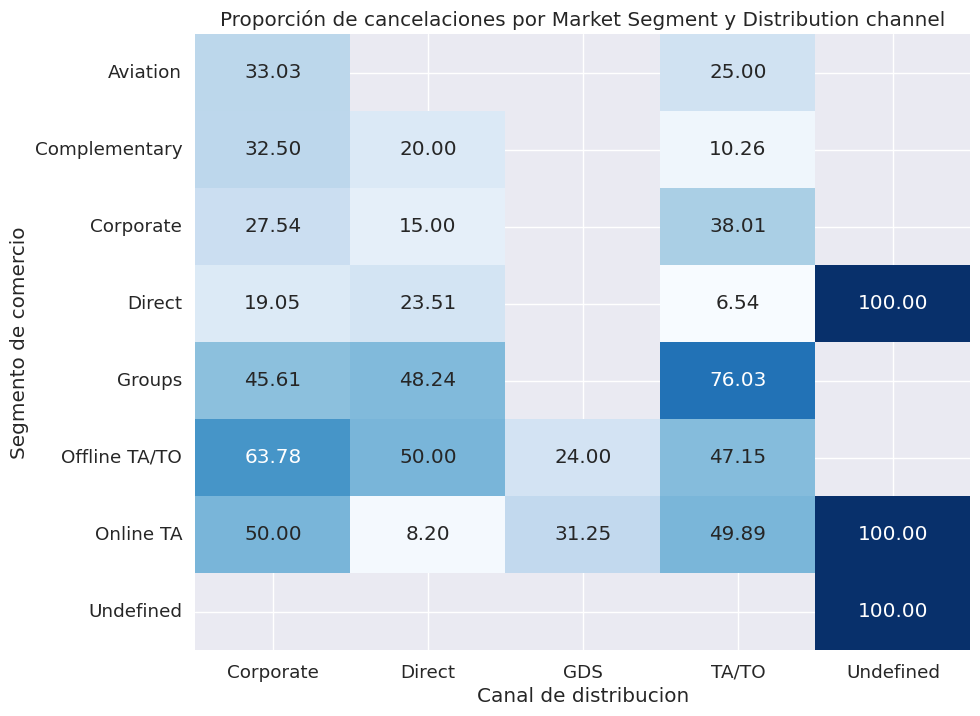

In [630]:
grouped = (df_hotels_train.groupby(['market_segment', 'distribution_channel'])['is_canceled'].mean() * 100 ).reset_index() 
pivot = grouped.pivot('market_segment', 'distribution_channel', 'is_canceled')
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(pivot, cmap='Blues', annot=True, fmt=".2f", cbar=False)
ax.set_xlabel('Canal de distribucion')
ax.set_ylabel('Segmento de comercio')
ax.set_title('Proporción de cancelaciones por Market Segment y Distribution channel')
plt.show()

Anteriormente pudimos observar que, el tiempo en donde se hacen la mayoria de las reservas, es entre Julio y Agosto. El hotel _City_ en temporada alta de demanda, recurre a aumentar los precios de las reservas, lo cual puede explicar el porqué tiene una tasa de cancelación alta.
Por otro lado, el hotel _Resort_, no aumenta el precio en temporada alta, por lo tanto puede explicar por qué posee menos cancelaciones que el hotel _City_.

## Inputacion de datos